In [1]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web
from qiskit_finance.applications.optimization import PortfolioDiversification

In [2]:
%matplotlib inline

In [3]:
# assets = ["AAPL", "GS", "JPM", "MSFT", "MCD", "WMT"]
# assets = ["AMZN", "BAC", "CVX", "SPY"]

In [4]:
# set number of assets (= number of qubits)

seed = 123

assets = ["AAPL", "MSFT", "MCD", "WMT"]

# Using data from yahoo finance
# use the name listed for particular company that you wish to add

import yfinance as yf
import numpy as np
stocks_data_csv= yf.download(assets, start = '2013-01-01', end = '2021-12-31')['Adj Close']
stocks_data_csv.to_csv("Stocks_data.csv")

[*********************100%***********************]  4 of 4 completed


In [5]:
read_stocks_data = pd.read_csv("Stocks_data.csv", index_col=False)
read_stocks_data

,Date,AAPL,MCD,MSFT,WMT
0,2012-12-31,16.344986,67.065506,22.024326,54.645313
1,2013-01-02,16.862822,68.517677,22.774689,55.454205
2,2013-01-03,16.649977,68.905411,22.469595,55.101818
3,2013-01-04,16.186203,68.312386,22.049063,55.310051
4,2013-01-07,16.090992,69.118309,22.007832,54.781460
...,...,...,...,...,...
2262,2021-12-23,175.262817,260.124146,331.583008,137.331253
2263,2021-12-27,179.289444,262.363922,339.270996,138.581573
2264,2021-12-28,178.255432,262.011841,338.082123,140.570328
2265,2021-12-29,178.344925,262.608459,338.775665,140.501419


In [6]:
stocks_data = read_stocks_data.drop(['Date'], axis=1)
stocks_data


,AAPL,MCD,MSFT,WMT
0,16.344986,67.065506,22.024326,54.645313
1,16.862822,68.517677,22.774689,55.454205
2,16.649977,68.905411,22.469595,55.101818
3,16.186203,68.312386,22.049063,55.310051
4,16.090992,69.118309,22.007832,54.781460
...,...,...,...,...
2262,175.262817,260.124146,331.583008,137.331253
2263,179.289444,262.363922,339.270996,138.581573
2264,178.255432,262.011841,338.082123,140.570328
2265,178.344925,262.608459,338.775665,140.501419


In [7]:
log_return = np.log(stocks_data/stocks_data.shift(1))
trading_days = log_return.shape[0]


num_assets = len(assets)
mu = log_return.mean()*trading_days
sigma = log_return.cov()*trading_days
sigma = np.array(sigma)
mu = np.array(mu)

In [8]:
log_return.head()

,AAPL,MCD,MSFT,WMT
0,NaN,NaN,NaN,NaN
1,0.031190,0.021422,0.033502,0.014694
2,-0.012702,0.005643,-0.013487,-0.006375
3,-0.028250,-0.008644,-0.018893,0.003772
4,-0.005900,0.011729,-0.001872,-0.009603


In [9]:
percetn_return = stocks_data.pct_change()
percetn_return.head()

,AAPL,MCD,MSFT,WMT
0,NaN,NaN,NaN,NaN
1,0.031682,0.021653,0.034070,0.014803
2,-0.012622,0.005659,-0.013396,-0.006355
3,-0.027854,-0.008606,-0.018716,0.003779
4,-0.005882,0.011798,-0.001870,-0.009557


### Conclusion 1 - log returns n percet change returns give the same value as an output..

In [10]:
stocks_data.head() # yf

,AAPL,MCD,MSFT,WMT
0,16.344986,67.065506,22.024326,54.645313
1,16.862822,68.517677,22.774689,55.454205
2,16.649977,68.905411,22.469595,55.101818
3,16.186203,68.312386,22.049063,55.310051
4,16.090992,69.118309,22.007832,54.781460


In [11]:
# print("returns ", mu)
# print("cov ", sigma)

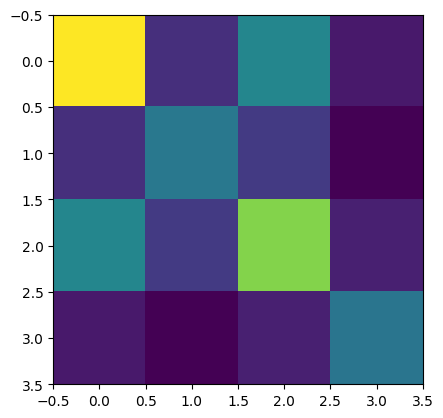

In [12]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [13]:
q = 0.5 # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.3602088740073782*x_0^2 + 0.193978922332834*x_0*x..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [14]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


iterations = []
bitstring = []
values = []
probabilityy = []



def store_results_nes(result, iter):
# for j in range(maxiter):
    selection = result.x
    value = result.fval
    # print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = list(reversed(np.argsort(eigenvector)))
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        
        iterations.append(iter)
        bitstring.append(selection)
        values.append(value)
        # probability = probabilities[i]
        probabilityy.append(probabilities[i])
        
        df_input={'iterations ':iterations}
        df = pd.DataFrame(df_input)
        df['optimal_bitstring']=pd.Series(list(bitstring))
        df['values']=pd.Series(values)
        df['probability'] = pd.Series(probabilityy)
        
        df.to_csv("portfolio_intermediate_results-nes.csv", index=False)
    

In [15]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
best_sample = result.x
best_sample
# [1. 0. 0. 1]

array([1., 0., 1., 0.])

In [16]:
maxiter = 1

for iter in range(maxiter):
    exact_mes = NumPyMinimumEigensolver()
    exact_eigensolver = MinimumEigenOptimizer(exact_mes)

    result = exact_eigensolver.solve(qp)
    algo = "nes"
    store_results_nes(result, iter)

In [17]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x

iterations = []
bitstring = []
values = []
probabilityy = []

def store_results_vqe_cobyla(result, iter):
# for j in range(maxiter):
    selection = result.x
    value = result.fval

    #clear the df as its giving the values of previous run into the next run.. 
    ## i.e. previoous nes into vqe algo
    # hence we need to copy this function seperatelly for every run

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = list(reversed(np.argsort(eigenvector)))
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        # print(x)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        
        iterations.append(iter)
        bitstring.append(selection)
        values.append(value)
        # probability = probabilities[i]
        probabilityy.append(probabilities[i])
        
        df_input={'iterations ':iterations}
        df = pd.DataFrame(df_input)
        df['optimal_bitstring']=pd.Series(list(bitstring))
        df['values']=pd.Series(values)
        df['probability'] = pd.Series(probabilityy)
        
        df.to_csv("portfolio_intermediate_results-Vqe_cobyla.csv", index=False)

In [18]:
# VQE + Cobyla
from qiskit.utils import algorithm_globals
maxiter=10

for iter in range(maxiter):
    algorithm_globals.random_seed = 1234
    backend = Aer.get_backend("statevector_simulator")
    optimizer = COBYLA(maxiter=iter)
    ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
    quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
    vqe_mes = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance)
    vqe = MinimumEigenOptimizer(vqe_mes)
    # print(np.array(vqe))
    # VQE.construct_circuit(ry, qp.qubit_op())
    result = vqe.solve(qp)
    store_results_vqe_cobyla(result, iter)

[1 0 0 1]
[0 0 0 1]
[0 0 0 0]
[1 1 1 1]
[0 1 1 1]
[0 0 1 0]
[1 0 0 0]
[1 1 0 0]
[0 0 1 1]
[1 0 1 0]
[1 0 1 1]
[0 1 1 0]
[1 1 1 0]
[1 1 0 1]
[0 1 0 0]
[0 1 0 1]
[1 0 0 1]
[0 0 0 1]
[0 0 0 0]
[1 1 1 1]
[0 1 1 1]
[0 0 1 0]
[1 0 0 0]
[1 1 0 0]
[0 0 1 1]
[1 0 1 0]
[1 0 1 1]
[0 1 1 0]
[1 1 1 0]
[1 1 0 1]
[0 1 0 0]
[0 1 0 1]
[1 0 0 1]
[0 0 0 1]
[0 0 0 0]
[1 1 1 1]
[0 1 1 1]
[0 0 1 0]
[1 0 0 0]
[1 1 0 0]
[0 0 1 1]
[1 0 1 0]
[1 0 1 1]
[0 1 1 0]
[1 1 1 0]
[1 1 0 1]
[0 1 0 0]
[0 1 0 1]
[1 0 0 1]
[0 0 0 1]
[0 1 1 1]
[1 1 1 1]
[0 0 1 1]
[1 1 1 0]
[0 0 0 0]
[1 0 1 0]
[1 0 1 1]
[1 1 0 0]
[0 0 1 0]
[0 1 1 0]
[1 1 0 1]
[1 0 0 0]
[0 1 0 1]
[0 1 0 0]
[1 0 0 1]
[0 0 0 1]
[0 1 1 1]
[1 1 1 1]
[0 0 1 1]
[1 1 1 0]
[0 0 0 0]
[1 0 1 0]
[1 0 1 1]
[1 1 0 0]
[0 0 1 0]
[0 1 1 0]
[1 1 0 1]
[1 0 0 0]
[0 1 0 1]
[0 1 0 0]
[1 0 0 1]
[0 0 0 1]
[0 1 1 1]
[1 1 1 1]
[0 0 1 1]
[1 1 1 0]
[0 0 0 0]
[1 0 1 0]
[1 0 1 1]
[1 1 0 0]
[0 0 1 0]
[0 1 1 0]
[1 1 0 1]
[1 0 0 0]
[0 1 0 1]
[0 1 0 0]
[1 0 0 1]
[0 1 1 1]
[1 1 0 0]
[0 0 0 0]


In [19]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x

iterations = []
bitstring = []
values = []
probabilityy = []

def store_results_vqe_spsa(result, iter):
# for j in range(maxiter):
    selection = result.x
    value = result.fval

    #clear the df as its giving the values of previous run into the next run.. 
    ## i.e. previoous nes into vqe algo
    # hence we need to copy this function seperatelly for every run

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = list(reversed(np.argsort(eigenvector)))
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        
        iterations.append(iter)
        bitstring.append(selection)
        values.append(value)
        # probability = probabilities[i]
        probabilityy.append(probabilities[i])
        
        df_input={'iterations ':iterations}
        df = pd.DataFrame(df_input)
        df['optimal_bitstring']=pd.Series(list(bitstring))
        df['values']=pd.Series(values)
        df['probability'] = pd.Series(probabilityy)
        
        df.to_csv("portfolio_intermediate_results-Vqe_spsa.csv", index=False)

In [20]:
##  VQE+SPSA
from qiskit.utils import algorithm_globals
maxiter=10
for iter in range(maxiter):
    algorithm_globals.random_seed = 1234
    backend = Aer.get_backend("statevector_simulator")
    optimizer = SPSA(maxiter=iter)
    ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
    quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
    vqe_mes = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance)
    vqe = MinimumEigenOptimizer(vqe_mes)
    result = vqe.solve(qp)
    # algo = "vqe-spsa"
    store_results_vqe_spsa(result, iter)

### QAOA

In [32]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x

iterations = []
bitstring = []
values = []
probabilityy = []

def store_results_qaoa_cobyla(result, iter):
# for j in range(maxiter):
    selection = result.x
    value = result.fval

    #clear the df as its giving the values of previous run into the next run.. 
    ## i.e. previoous nes into vqe algo
    # hence we need to copy this function seperatelly for every run

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = list(reversed(np.argsort(eigenvector)))
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        
        iterations.append(iter)
        bitstring.append(selection)
        values.append(value)
        # probability = probabilities[i]
        probabilityy.append(probabilities[i])
        
        df_input={'iterations ':iterations}
        df = pd.DataFrame(df_input)
        df['optimal_bitstring']=pd.Series(list(bitstring))
        df['values']=pd.Series(values)
        df['probability'] = pd.Series(probabilityy)
        
        df.to_csv("portfolio_intermediate_results-qaoa_cobyla.csv", index=False)
        # df_lst = [df]
        # del df

In [33]:
## QAOA + Cobyla
from qiskit.utils import algorithm_globals
maxiter=10
algo = "qaoa-cobyla"
for iter in range(maxiter):
    algorithm_globals.random_seed = 1234
    backend = Aer.get_backend("statevector_simulator")
    optimizer = COBYLA(maxiter=iter)
    quantum_instance = QuantumInstance(backend=backend, shots=8192) 
    qaoa_mes = QAOA(optimizer=optimizer, reps=3, quantum_instance=quantum_instance)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)
    store_results_qaoa_cobyla(result, iter)

In [34]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x

iterations = []
bitstring = []
values = []
probabilityy = []

def store_results_qaoa_spsa(result, iter):
# for j in range(maxiter):
    selection = result.x
    value = result.fval

    #clear the df as its giving the values of previous run into the next run.. 
    ## i.e. previoous nes into vqe algo
    # hence we need to copy this function seperatelly for every run

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = list(reversed(np.argsort(eigenvector)))
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        
        iterations.append(iter)
        bitstring.append(selection)
        values.append(value)
        # probability = probabilities[i]
        probabilityy.append(probabilities[i])
        
        df_input={'iterations ':iterations}
        df = pd.DataFrame(df_input)
        df['optimal_bitstring']=pd.Series(list(bitstring))
        df['values']=pd.Series(values)
        df['probability'] = pd.Series(probabilityy)
        
        df.to_csv("portfolio_intermediate_results-qaoa_spsa.csv", index=False)

In [35]:
## QAOA + SPSA
from qiskit.utils import algorithm_globals
maxiter=10
for j in range(maxiter):
    algorithm_globals.random_seed = 1234
    backend = Aer.get_backend("statevector_simulator")
    optimizer = SPSA(maxiter=j)
    quantum_instance = QuantumInstance(backend=backend, shots=8192) 
    qaoa_mes = QAOA(optimizer=optimizer, reps=3, quantum_instance=quantum_instance)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)
    # algo = "qaoa-spsa"
    store_results_qaoa_spsa(result, maxiter)

In [39]:
vqe_cobyla_file = pd.read_csv("portfolio_intermediate_results-Vqe_spsa.csv")
vqe_cobyla_file

,iterations,optimal_bitstring,values,probability
0,0,[1. 0. 1. 0.],-2.643301,0.423773
1,0,[1. 0. 1. 0.],-0.773496,0.183462
2,0,[1. 0. 1. 0.],0.000000,0.135737
3,0,[1. 0. 1. 0.],-5.168635,0.055928
4,0,[1. 0. 1. 0.],-3.884513,0.029931
...,...,...,...,...
155,9,[1. 0. 1. 0.],-4.509002,0.000012
156,9,[1. 0. 1. 0.],-5.168635,0.000018
157,9,[1. 0. 1. 0.],-4.055699,0.000046
158,9,[1. 0. 1. 0.],-3.884513,0.000838


#### weight allocation part after asset selection using quantum

In [40]:
# selected_assets = [1, 0, 0, 1, 1, 0] #, 0, 0, 1, 1, 1, 1]
selected_assets = best_sample

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['AAPL', 'MCD']


In [41]:
log_return = log_return[my_assets]
log_return.head()

,AAPL,MCD
0,NaN,NaN
1,0.031190,0.021422
2,-0.012702,0.005643
3,-0.028251,-0.008644
4,-0.005899,0.011728


In [42]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * trading_days
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*trading_days,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [43]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [44]:
# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets))) 
init_guess = np.random.dirichlet(np.ones(len(my_assets)),size=1)

In [45]:
# # weights_array = dict(('w'+str(i), []) for i in range(len(my_assets)) )#['A','B','C','D'])
# # weights_list = list(weights_array.keys())
# # weights_list[0]


# import numpy as np
# # from scipy.optimize import fmin_bfgs;

# iterations = []
# weights_listt = []
# function_list = []
# Nfeval = 1

# def callbackF(weights):
#     global Nfeval
#     iterations.append(Nfeval)
#     print(iterations)
#     weights_listt.append([weights[j] for j in range(len(my_assets))])
    
#     print(weights_listt)
#     function_list.append(neg_sharpe(weights_listt[-1]))
#     print(function_list[-1])
#     data={'Iterations ':iterations}
#     df1 = pd.DataFrame(data)
#     df1['weights array']=pd.Series(weights_listt) #newly added
#     df1['shape ratio']=pd.Series(function_list)
#     df1.to_csv('portfolio_weights_iteration.csv', index=False)
#     Nfeval += 1


# opt_results = minimize(neg_sharpe, init_guess, callback=callbackF, method='SLSQP', bounds=bounds, constraints=cons, options= {'maxiter' : 2000, 'disp':True})

In [46]:
import numpy as np

iterations = []
weights_listt = []
function = []
returns = []
risk = []
sharpe_ratio = []

Nfeval = 1

def callbackF(weights):
    global Nfeval
    iterations.append(Nfeval)
    # print(iterations)
    weights_listt.append([weights[j] for j in range(len(my_assets))])
    
    my_weights = np.array(weights_listt[-1])
    
    ret = np.sum(log_return.mean() * my_weights) * trading_days # returns of a portfolio after optimum weight allocation
    returns.append(ret)
    vol = np.sqrt(np.dot(my_weights.T,np.dot(log_return.cov()*trading_days,my_weights))) # risk of a portfolio after optimum weight allocation
    risk.append(vol)
    sharpe_ratio.append(ret/vol)    # print(weights_listt[-1])
    function.append(neg_sharpe(weights_listt[-1]))
    # print(function_list[-1])
    data={'Iterations ':iterations}
    df1 = pd.DataFrame(data)
    df1['weights array']=pd.Series(weights_listt) 
    df1['function']=pd.Series(function)#newly added
    df1['returns']=pd.Series(returns)
    df1['risk']=pd.Series(risk)
    df1['shape ratio']=pd.Series(sharpe_ratio)
    df1.to_csv('portfolio_weights_iter.csv', index=False)
    Nfeval += 1


opt_results = minimize(neg_sharpe, init_guess, callback=callbackF, method='SLSQP', bounds=bounds, constraints=cons, options= {'maxiter' : 2000, 'disp':True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.0974090557404423
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5


/tmp/ipykernel_19752/3622933343.py:38: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt_results = minimize(neg_sharpe, init_guess, callback=callbackF, method='SLSQP', bounds=bounds, constraints=cons, options= {'maxiter' : 2000, 'disp':True})


In [47]:
opt_results.x

array([0.53009938, 0.46990062])

In [48]:
df =pd.read_csv("portfolio_weights_iter.csv")
# df = df["weights array"]
df 

,Iterations,weights array,function,returns,risk,shape ratio
0,1,"[1.0, 0.0]",-2.809049,2.384250,0.848775,2.809049
1,2,"[0.5519864313249373, 0.4480135686750627]",-3.096286,1.925737,0.621951,3.096286
2,3,"[0.5265761720239132, 0.4734238279760869]",-3.097382,1.899732,0.613335,3.097382
3,4,"[0.5300993797880628, 0.46990062021193735]",-3.097409,1.903337,0.614493,3.097409
4,5,"[0.5300993797880628, 0.46990062021193735]",-3.097409,1.903337,0.614493,3.097409


In [49]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [50]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [51]:
weights_alloc = dict(zip(my_assets, my_weights))
weights_alloc

{'AAPL': 0.5300993797880628, 'MCD': 0.46990062021193735}

In [52]:
# weights_alloc.values()

In [53]:
my_weights

[0.5300993797880628, 0.46990062021193735]

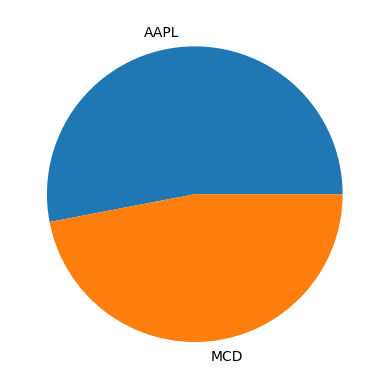

In [54]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(my_weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

## return risk n sharpe ratio 
#### annual_returns vs daily_returns

In [55]:
# annual returns
ret = np.sum(log_return.mean() * my_weights) * 252
vol = np.sqrt(np.dot(np.array(my_weights).T,np.dot(log_return.cov()*252,my_weights)))
sr = ret/vol 

risk_ret_dict = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sr 
}

risk_ret_dict

{'returns': 21.157520934681123,
 'risk': 20.487629192614392,
 'sharpe_ratio': 1.032697377318222}

In [56]:
# daily_returns*number of days in dataframe
ret = np.sum(log_return.mean() * my_weights) * trading_days
vol = np.sqrt(np.dot(np.array(my_weights).T,np.dot(log_return.cov()*trading_days,my_weights)))
sr = ret/vol 

risk_ret_dict = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sr 
}

risk_ret_dict

{'returns': 190.33372999572265,
 'risk': 61.449336064597695,
 'sharpe_ratio': 3.0974090557404423}

## How our portfolio beats index..

In [59]:
index_data = yf.download("^DJI", start = '2013-01-01', end = '2021-12-31')["Adj Close"]
index_data  = pd.Series(index_data, name = "index_vals")

[*********************100%***********************]  1 of 1 completed


In [60]:
# portfolio_data = yf.download(my_assets, start = '2013-01-01', end = '2021-12-31')["Adj Close"]
portfolio_data = stocks_data_csv[my_assets]
portfolio_data["portfolio_vals"] = portfolio_data.mean(axis =1)
portfolio_data = portfolio_data["portfolio_vals"]
portfolio_df = portfolio_data.to_frame(name = "portfolio_vals")
portfolio_df = portfolio_df.rename_axis('Dates', axis=1)
portfolio_df

/tmp/ipykernel_19752/3694130034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_data["portfolio_vals"] = portfolio_data.mean(axis =1)


Dates,portfolio_vals
Date,
2012-12-31,41.894115
2013-01-02,42.883198
2013-01-03,42.971755
2013-01-04,42.441669
2013-01-07,42.799282
...,...
2021-12-23,218.425972
2021-12-27,221.565498
2021-12-28,220.871468


In [61]:
index_first = index_data.iloc[0]
portfolio_first = portfolio_data.iloc[0]

index_data  = index_data.multiply(portfolio_first/index_first)

index_df = index_data.to_frame(name = "index_vals")
index_df = index_df.rename_axis('Dates', axis=1)
# print(type(index_df)
index_df.tail()

Dates,index_vals
Date,
2021-12-23,114.934432
2021-12-27,116.059207
2021-12-28,116.365583
2021-12-29,116.654651
2021-12-30,116.365158


In [62]:
portfolio_df.columns

Index(['portfolio_vals'], dtype='object', name='Dates')

In [65]:
#portfolio to index effecive ratio 

portfolio_index_effective_ratio = float(portfolio_df.values[-1] / index_df.values[-1])
print(" effective ratio ", portfolio_index_effective_ratio)

 effective ratio  1.8906011218357686


In [66]:
#portfolio to index average ratio 

portfolio_val = portfolio_data.mean()
index_val = index_data.mean()

portfolio_index_avg_ratio = portfolio_val / index_val
print(" avearge ratio ", portfolio_index_avg_ratio)

 avearge ratio  1.3004912592989912


In [67]:
portfolio_df.tail()

Dates,portfolio_vals
Date,
2021-12-23,218.425972
2021-12-27,221.565498
2021-12-28,220.871468
2021-12-29,221.216194
2021-12-30,220.000099


In [68]:
df = pd.concat([index_df, portfolio_df], axis=1).reset_index()
df.columns

Index(['Date', 'index_vals', 'portfolio_vals'], dtype='object', name='Dates')

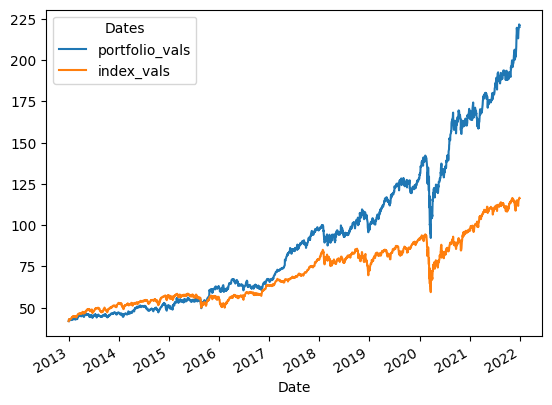

In [69]:
df.plot(x="Date", y=["portfolio_vals", "index_vals"])
plt.show()

In [70]:
my_assets

['AAPL', 'MCD']